# Image Classification Project

In [131]:
from keras import layers
from keras import models
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.models import Model
from keras.layers import Input
from keras.layers.merge import concatenate
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import read_csv
from sklearn.preprocessing import LabelEncoder
from pandas import DataFrame
from pandas import concat
from math import sqrt
from numpy import concatenate
import tensorflow as tf
#import keras_metrics
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.pipeline import make_pipeline
from sklearn import svm, datasets
from sklearn import metrics
from sklearn import preprocessing
import datetime as dt
import urllib.request, json
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
#import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.layers import Input
from keras.applications.resnet50 import ResNet50
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, CSVLogger, LearningRateScheduler, ReduceLROnPlateau
from keras.optimizers import SGD
from keras.regularizers import l2
import keras.backend as K
from keras.models import Sequential, Model, load_model
import math
from keras.applications.mobilenetv2 import MobileNetV2 as PTModel
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Input, Conv2D, multiply, LocallyConnected2D, Lambda
from keras.models import Model
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
from PIL import Image

%matplotlib inline

### Load data function

In [133]:
def load_dataset():
    train_dataset = h5py.File('data-64/X_train.h5', "r")
    train_set_x = np.array(train_dataset["X_train"]) # train set features
    train_y = h5py.File('data-64/y_train.h5', "r")
    train_set_y = np.array(train_y["y_train"]) # train set labels

    test_dataset = h5py.File('data-64/X_test.h5', "r")
    test_set_x = np.array(test_dataset["X_test"]) # test set features
    test_y = h5py.File('data-64/y_test.h5', "r")
    test_set_y = np.array(test_y["y_test"]) # test set labels

    #classes = np.array(test_dataset["list_classes"][:]) # list of classes
    
    train_set_y = train_set_y.reshape((1, train_set_y.shape[0]))
    test_set_y = test_set_y.reshape((1, test_set_y.shape[0]))
    
    return train_set_x, train_set_y, test_set_x, test_set_y

#### Load data to train and test set

In [4]:
X_train, Y_train, X_test, Y_test = load_dataset()

In [5]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

In [6]:
Y_train = convert_to_one_hot(Y_train,101).T
Y_test = convert_to_one_hot(Y_test, 101).T
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))
conv_layers = {}

number of training examples = 75747
number of test examples = 25250
X_train shape: (75747, 64, 64, 3)
Y_train shape: (75747, 101)
X_test shape: (25250, 64, 64, 3)
Y_test shape: (25250, 101)


#### Image Augmentation for test data

In [122]:
test_datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False, # randomly flip images
        zoom_range=[.8, 1],
        channel_shift_range=30,
        fill_mode='reflect')

test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow(X_test, Y_test, batch_size=64, seed=11)

### Train model on training data

In [9]:
%%time
import tensorflow as tf
with tf.device('/gpu:0'):
    X_train, Y_train, X_test, Y_test = load_dataset()
    Y_train = convert_to_one_hot(Y_train,101).T
    Y_test = convert_to_one_hot(Y_test, 101).T
    n_classes = 101
    
    # this is the augmentation configuration we will use for training
    train_datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False, # randomly flip images
        zoom_range=[.8, 1],
        channel_shift_range=30,
        fill_mode='reflect')

    train_generator = train_datagen.flow(X_train, Y_train, batch_size=64, seed=11)
    
    
    #fit model

    K.clear_session()
    
    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(64,64, 3)))


    x = base_model.output
    x = AveragePooling2D(pool_size=(2, 2))(x)
    x = Dropout(.4)(x)
    x = Flatten()(x)
    predictions = Dense(n_classes, init='glorot_uniform', W_regularizer=l2(.0005), activation='softmax')(x)

    model = Model(input=base_model.input, output=predictions)

   


    model = load_model(filepath='./model4.34-2.23.hdf5')

    opt = SGD(lr=0.01, momentum=.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    checkpointer = ModelCheckpoint(filepath='model5.{epoch:02d}-{val_loss:.2f}.hdf5', verbose=1, save_best_only=True)
    csv_logger = CSVLogger('model5.log')

    def schedule(epoch):
        if epoch < 35:
            return .01
        elif epoch < 45:
            return .001
        else:
            return .0001
    lr_scheduler = LearningRateScheduler(schedule)

    #model.fit_generator(train_generator,
                        validation_data=test_generator,
                        nb_val_samples=X_test.shape[0],
                        steps_per_epoch=X_train.shape[0]//32,
                        nb_epoch=50,
                        verbose=2,
                        callbacks=[lr_scheduler, csv_logger, checkpointer])

    

Instructions for updating:
Colocations handled automatically by placer.


/usr/local/lib/python3.5/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:39: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(101, kernel_regularizer=<keras.reg..., activation="softmax", kernel_initializer="glorot_uniform")`
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:41: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`


Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:69: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:69: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_steps=25250, epochs=50, validation_data=<keras_pre..., steps_per_epoch=2367, callbacks=[<keras.ca..., verbose=2)`


Epoch 1/50
 - 1011s - loss: 2.5355 - acc: 0.3835 - val_loss: 3.1616 - val_acc: 0.2674

Epoch 00001: val_loss improved from inf to 3.16162, saving model to model5.01-3.16.hdf5
Epoch 2/50
 - 987s - loss: 2.4753 - acc: 0.3999 - val_loss: 2.7878 - val_acc: 0.3439

Epoch 00002: val_loss improved from 3.16162 to 2.78784, saving model to model5.02-2.79.hdf5
Epoch 3/50
 - 988s - loss: 2.3886 - acc: 0.4208 - val_loss: 3.1839 - val_acc: 0.2883

Epoch 00003: val_loss did not improve from 2.78784
Epoch 4/50
 - 986s - loss: 2.3055 - acc: 0.4379 - val_loss: 2.7743 - val_acc: 0.3530

Epoch 00004: val_loss improved from 2.78784 to 2.77427, saving model to model5.04-2.77.hdf5
Epoch 5/50
 - 988s - loss: 2.2389 - acc: 0.4538 - val_loss: 2.9158 - val_acc: 0.3387

Epoch 00005: val_loss did not improve from 2.77427
Epoch 6/50
 - 992s - loss: 2.1778 - acc: 0.4675 - val_loss: 2.5257 - val_acc: 0.4054

Epoch 00006: val_loss improved from 2.77427 to 2.52565, saving model to model5.06-2.53.hdf5
Epoch 7/50
 - 986

In [11]:
import pickle
filename = 'finalized_model.sav'
#pickle.dump(model, open(filename, 'wb'))

In [14]:
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [124]:
loaded_model = pickle.load(open(filename, 'rb'))

In [125]:
#train model on validation set
with tf.device('/gpu:0'):
    
    opt = SGD(lr=0.01, momentum=.9)
    loaded_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    checkpointer = ModelCheckpoint(filepath='model7.{epoch:02d}.hdf5', verbose=1, save_best_only=True)
    csv_logger = CSVLogger('model7.log')

    def schedule(epoch):
        if epoch < 6:
            return .01
        else:
            return .001
    lr_scheduler = LearningRateScheduler(schedule)
    
    loaded_model.fit_generator(test_generator,
                        
                        steps_per_epoch=X_test.shape[0]//32,
                        nb_epoch=10,
                        verbose=2,
                        callbacks=[lr_scheduler, csv_logger, checkpointer])

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:22: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:22: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., epochs=10, verbose=2, callbacks=[<keras.ca..., steps_per_epoch=789)`


Epoch 1/10
 - 118s - loss: 1.7161 - acc: 0.5894
Epoch 2/10


/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:434: RuntimeWarning: Can save best model only with val_loss available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


 - 79s - loss: 0.7454 - acc: 0.8150
Epoch 3/10
 - 78s - loss: 0.3397 - acc: 0.9247
Epoch 4/10
 - 79s - loss: 0.2281 - acc: 0.9582
Epoch 5/10
 - 79s - loss: 0.1809 - acc: 0.9727
Epoch 6/10
 - 79s - loss: 0.1575 - acc: 0.9777
Epoch 7/10
 - 79s - loss: 0.1117 - acc: 0.9917
Epoch 8/10
 - 79s - loss: 0.0966 - acc: 0.9961
Epoch 9/10
 - 79s - loss: 0.0920 - acc: 0.9971
Epoch 10/10
 - 79s - loss: 0.0890 - acc: 0.9978


In [148]:
import pickle
filename = 'final_model_val.sav'
pickle.dump(loaded_model, open(filename, 'wb'))

#### Validation set accuracy

In [126]:
pred_y=model.predict(X_test)
zero_y=np.zeros(pred_y.shape)
argmax_lst=np.argmax(pred_y,axis=1)
for i in range(len(argmax_lst)):
    zero_y[i][argmax_lst[i]]=1
pred_y=zero_y
from sklearn.metrics import f1_score,accuracy_score
print("Acc-Score:",accuracy_score(np.array(Y_test),np.array(pred_y)))

Acc-Score: 0.9991683168316832


In [134]:
def decode(datum):
    return np.argmax(datum)

decoded_pred_y = []
for i in range(pred_y.shape[0]):
    datum = pred_y[i]
    #print('index: %d' % i)
    #print('encoded datum: %s' % datum)
    decoded_datum = decode(pred_y[i])
    decoded_pred_y.append(decoded_datum)
    #print('decoded datum: %s' % decoded_datum)
    #print()

decoded_test_y = []
for i in range(Y_test.shape[0]):
    datum = Y_test[i]
    #print('index: %d' % i)
    #print('encoded datum: %s' % datum)
    decoded_datum_test = decode(Y_test[i])
    decoded_test_y.append(decoded_datum_test)

fig=plt.figure(figsize=(20,20))
n=25
col=5
for i in range(n):
    ax=fig.add_subplot(n/col,col,i+1)
    j = np.random.randint(2000)
    #img[i] = f["images"][i].squeeze()
    ax.set_title(str(f["category_names"][decoded_pred_y[j]].decode()) +" "+ str(f["category_names"][decoded_test_y[j]].decode()) )
    ax.imshow(X_test[j])

In [152]:
%matplotlib inline

import os
from os import listdir
from os.path import isfile, join
import shutil
import stat
import collections
from collections import defaultdict

from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

import h5py

%matplotlib inline
import json
import matplotlib.pyplot as plt
import cv2
import os
import sys
import random

In [136]:
root_dir = 'food-101/images/'
rows = 10
cols = 5
#fig, ax = plt.subplots(rows, cols, frameon=False, figsize=(15, 25))
#fig.suptitle('Random Image from Each Food Class', fontsize=20)
sorted_food_dirs = sorted(os.listdir(root_dir))

In [137]:
class_to_ix = {}
ix_to_class = {}
with open('food-101/meta/classes.txt', 'r') as txt:
    classes = [l.strip() for l in txt.readlines()]
    class_to_ix = dict(zip(classes, range(len(classes))))
    ix_to_class = dict(zip(range(len(classes)), classes))
    class_to_ix = {v: k for k, v in ix_to_class.items()}
sorted_class_to_ix = collections.OrderedDict(sorted(class_to_ix.items()))

In [138]:
ix_to_class[23]

'churros'

In [144]:
#Import yelp data

photos = []
for line in open('photo.json', 'r'):
    photos.append(json.loads(line))
    
#get food photo
food =[]
drink =[]
inside = []
for i in range(len(photos)):
    if photos[i]['label'] == 'food':
        food.append(photos[i])
    elif photos[i]['label'] == 'drink':
        drink.append(photos[i])
    elif photos[i]['label'] == 'inside':
        inside.append(photos[i])
        
#get data
import glob
import numpy as np

X_data = []
files = glob.glob ("yelp_photos/*.jpg")
WIDTH = 64
HEIGHT = 64

for img in files:
        base = os.path.basename(img)
        #finding = labels["Finding Labels"][labels["Image Index"] == base].values[0]

        # Read and resize image
        full_size_image = plt.imread(img)
        X_data.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
        
out = [x[12:-4] for x in files]
#get food
actual_image = []
for i in range(len(food)):
    for j in range(len(out)):
        if food[i]['photo_id'] == out[j]:
            actual_image.append(X_data[j])
#print picture

yelp_img = np.array(actual_image)
print("Yelp image dataset shape: ",yelp_img.shape)

Yelp image dataset shape:  (119, 64, 64, 3)


In [143]:
pred_y_yelp=loaded_model.predict(yelp_img)

In [145]:
decoded_pred_y_yelp = []
for i in range(pred_y_yelp.shape[0]):
    datum = pred_y_yelp[i]
    #print('index: %d' % i)
    #print('encoded datum: %s' % datum)
    decoded_datum = decode(pred_y_yelp[i])
    decoded_pred_y_yelp.append(decoded_datum)

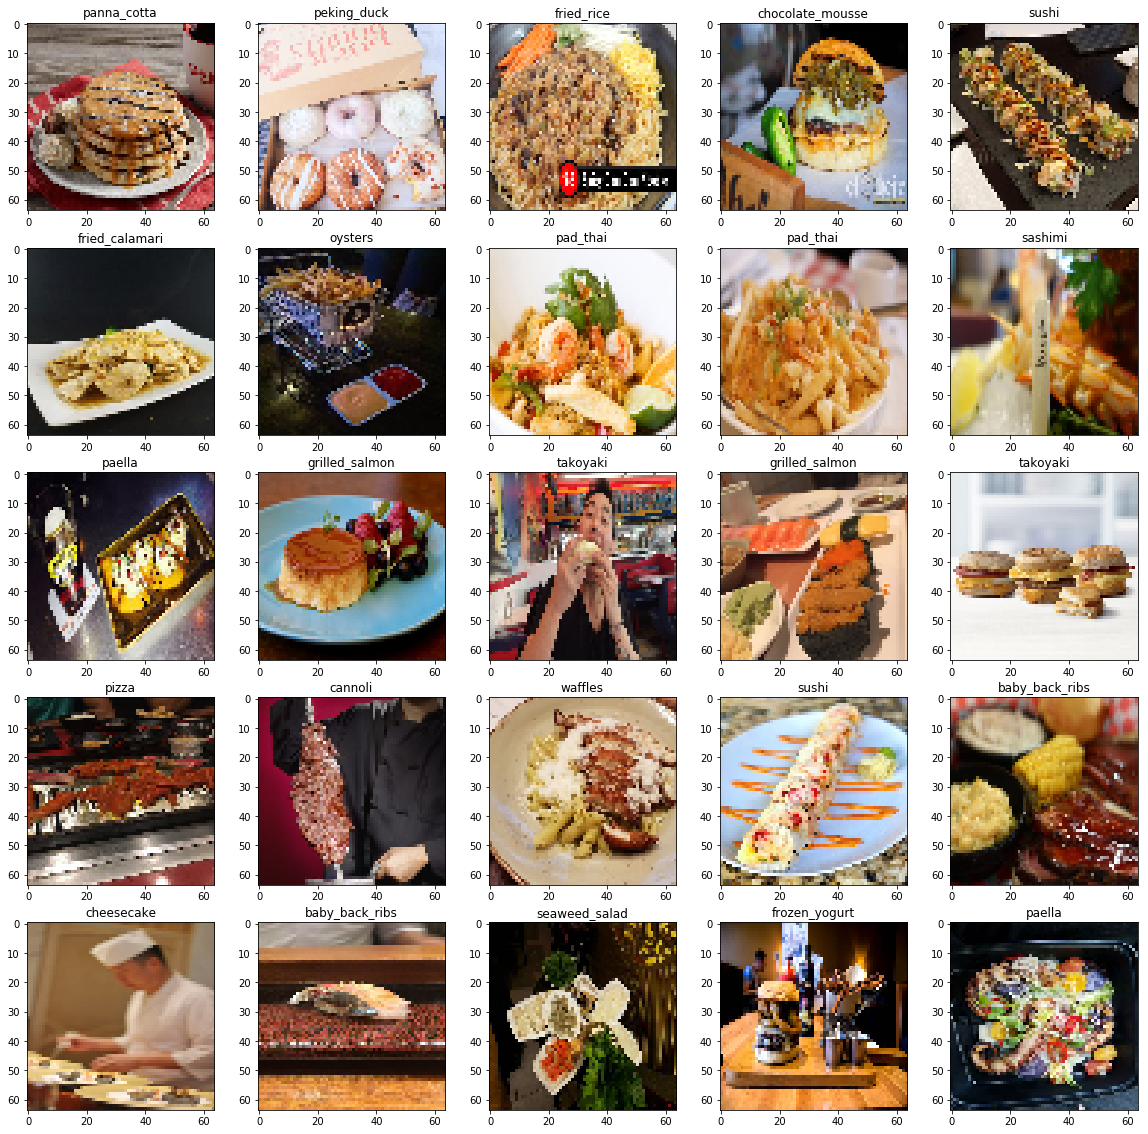

In [153]:
fig=plt.figure(figsize=(20,20))
list_num=  random.sample(range(100), 25)
n=25
col=5
for i in range(len(list_num)):
    ax=fig.add_subplot(n/col,col,i+1)
    j = list_num[i]
    m = yelp_img[j]
    #img[i] = f["images"][i].squeeze()
    ax.set_title(str(ix_to_class[decoded_pred_y_yelp[j]]) )
    ax.imshow(m)